In [20]:
import os
import torch
import numpy as np
import torch
import math
from torch import nn
from utils import spectrum1d, FourierFilter, get_lr, DatasetFluid2D, train_model_batch
from relaxed_gconv import TranSymDisNet
from relaxed_gconv import IsoSymDisNet2D, RelaxedRotCNN2d, RelaxedRotGroupConv2d
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Isotropy Breaking

In [17]:
sample = np.load("data/fluid/Re_180_1.npy")
sample = sample[None, :2]
T = sample.shape[2]
H = sample.shape[-2]
W = sample.shape[-1]
wave_numbers, spec_target = spectrum1d(sample)
# torch_sample = torch.from_numpy(sample).reshape(1, T*2, H, W)
# limits = torch.fft.rfftfreq(min(H, W))
# separate_scales = []
# for i in range(len(limits)-1):  
#     separate_scale = FourierFilter(torch_sample, limits[i], limits[i+1]).reshape(2, T, H, W).real.data.numpy()
#     np.save("data/fluid/scale_" + str(i) + ".npy", separate_scale)

/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '


In [13]:
class RelaxedRotCNN2d(torch.nn.Module):
    """A small relaxed rotation 2d CNN model"""
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 hidden_dim, 
                 group_order, # the order of 2d finite rotation group
                 num_gconvs, # number of group conv layers
                 num_filter_banks
                ):
        super(RelaxedRotCNN2d, self).__init__()
        
        self.group_order = group_order
        self.gconvs = []
        
        theta = torch.tensor(2*np.pi/self.group_order).float()
        self.lift_weights = torch.from_numpy(np.array([[np.cos(theta*i), np.sin(theta*i)] 
                                                       for i in range(self.group_order)])).float().to(device)

        self.gconvs.append(RelaxedRotGroupConv2d(in_channels = in_channels,
                                                 out_channels = hidden_dim,
                                                 kernel_size = kernel_size,
                                                 group_order = group_order,
                                                 num_filter_banks = num_filter_banks,
                                                 activation = True))
        
        for i in range(num_gconvs-2):
            self.gconvs.append(RelaxedRotGroupConv2d(in_channels = hidden_dim,
                                                     out_channels = hidden_dim,
                                                     kernel_size = kernel_size,
                                                     group_order = group_order,
                                                     num_filter_banks = num_filter_banks,
                                                     activation = True))
            
        self.gconvs.append(RelaxedRotGroupConv2d(in_channels = hidden_dim,
                                                 out_channels = out_channels,
                                                 kernel_size = kernel_size,
                                                 group_order = group_order,
                                                 num_filter_banks = num_filter_banks,
                                                 activation = False))

        self.gconvs = torch.nn.Sequential(*self.gconvs)

    def forward(self, x, mean = True): 
        # average over h axis or not   
        lift_x = torch.einsum("bvhw, gv -> bghw", x, self.lift_weights).unsqueeze(1)
        # print(lift_x.shape)
        out = self.gconvs(lift_x)
        if mean:
            out = out.mean(2)
        return out

In [14]:
all_equiv_errors = []
# Average over five runs with different random seeds
for seed in range(5):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    equiv_errors = []
    for s in range(64):
        in_channels = 1
        out_channels = 1
        kernel_size = 5
        hidden_dim = 16
        num_filter_basis = 1
        batch_size = 2
        train_indices = np.arange(0, 1800)

        data_direc = "data/fluid/scale_" + str(s) + ".npy"
        train_set = DatasetFluid2D(direc = data_direc, sample_list = train_indices)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)

        model = RelaxedRotCNN2d(in_channels = in_channels, 
                                out_channels = out_channels, 
                                kernel_size = kernel_size, 
                                hidden_dim = hidden_dim, 
                                group_order = 4, # the order of 2d finite rotation group
                                num_gconvs = 3, # number of group conv layers
                                num_filter_banks = 1).to(device)
        with torch.no_grad():
            all_outs = []
            for xx, yy in train_loader:
                xx = xx.to(device)
                yy = yy.to(device)
                preds = model(xx.to(device), mean = False)
                all_outs.append(preds)
            all_outs = torch.cat(all_outs, dim = 0) 
        # Normalization
        all_outs = (all_outs - torch.min(all_outs))/(torch.max(all_outs) - torch.min(all_outs))
        # Equiv Error
        equiv_errors.append(torch.mean(torch.abs(all_outs - all_outs[:,:,:1])).cpu().data.numpy())
        print(equiv_errors[-1])
    all_equiv_errors.append(equiv_errors)

0.13517518
0.0549782
0.04322963
0.034796562
0.0378226
0.03774978
0.032104418
0.03496139
0.04094966
0.029606875
0.0268868
0.031922273
0.028273333
0.02398223
0.024718586
0.026186906
0.03393533
0.02510246
0.021318126
0.024922634
0.016841982
0.02036282
0.023078306
0.01963833
0.016478788
0.017017754
0.017619789
0.011292996
0.009864543
0.007892102
0.007515028
0.006741224
0.0059868176
0.0069780117
0.00555392
0.0048446637
0.004468138
0.0027797779
0.003647254
0.0039392477
0.004310825
0.0037047013
0.003232369
0.0033432103
0.0035233533
0.0033868582
0.0038634418
0.0031390742
0.002901154
0.0029668098
0.002652898
0.0031397797
0.0026324373
0.003302332
0.0023944366
0.0023526908
0.002876326
0.002263374
0.0024724312
0.0022981835
0.0031814466
0.0015934529
0.0020082027
0.0023205236
0.28474233
0.05045408
0.034711577
0.03924585
0.029843573
0.028858533
0.025491463
0.03121431
0.034076843
0.027059086
0.03559157
0.03276373
0.03845707
0.029391142
0.022154856
0.02280499
0.027254613
0.024309171
0.028144494
0.01943

In [15]:
all_equiv_errors = np.array(all_equiv_errors)
std_equiv_error = np.std(all_equiv_errors, axis = 0)
avg_equiv_error = np.mean(all_equiv_errors, axis = 0)

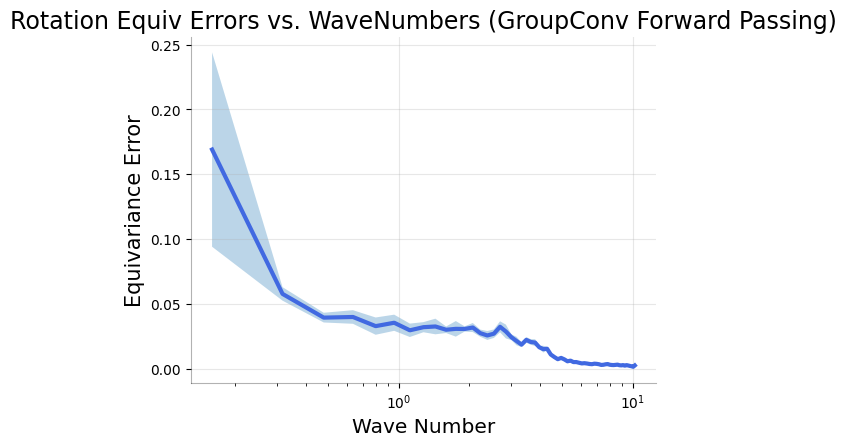

In [18]:
fig=plt.figure(figsize=(6, 4.5))
plt.plot(wave_numbers[1:], avg_equiv_error, color = "royalblue", linewidth = 3)
plt.fill_between(wave_numbers[1:], (avg_equiv_error-std_equiv_error), (avg_equiv_error+std_equiv_error), alpha=.3)
plt.ylabel("Equivariance Error", size = 15)
plt.xlabel("Wave Number", size = 14.5)
plt.title("Rotation Equiv Errors vs. WaveNumbers (GroupConv Forward Passing)", size = 17)
plt.grid(axis='both', alpha=.3)
plt.xscale("log")

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
# plt.show()
plt.savefig("iso_breaking_forward_passing.png", dpi = 200, bbox_inches = 'tight')

## Homogeneity Breaking

In [34]:
in_channels = 2
out_channels = 1
kernel_size = 3
h_size = 256
w_size = 128
hidden_dim = 16
num_filter_basis = 1
batch_size = 128
learning_rate = 0.001
decay_rate = 0.9
num_epoch = 100
train_indices = np.arange(0, 1800)

all_equiv_errors_seeds = []
for seed in range(5):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    data_direc = "data/fluid/Re_180_1.npy"

    train_set = DatasetFluid2D(direc = data_direc, sample_list = train_indices)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)

    model = TranSymDisNet(in_channels = in_channels, 
                          out_channels = out_channels, 
                          kernel_size = kernel_size, 
                          h_size = h_size, 
                          w_size = w_size, 
                          hidden_dim = hidden_dim, 
                          num_filter_basis = num_filter_basis).to(device)

    with torch.no_grad():
        all_outs = []
        for xx, yy in train_loader:
            xx = xx.to(device)
            yy = yy.to(device)
            preds = model(xx.to(device))
            all_outs.append(preds)
        all_outs = torch.cat(all_outs, dim = 0) 
    all_outs = all_outs.cpu().data.numpy()
    all_outs = (all_outs - all_outs.min((2), keepdims = True))/(all_outs.max((2), keepdims = True) - all_outs.min((2), keepdims = True))
    
#     # Calculate the equivariance error based on the learnt relaxed weights
#     # \sum_{g \in G} |w(e) - w(g)|
    equiv_error_y = np.mean(np.abs(all_outs - all_outs[:,:,63:64]), axis = -1).mean(0).mean(0)
    # break
    all_equiv_errors_seeds.append(equiv_error_y)

# std_equiv_error = np.std(all_equiv_errors_seeds, axis = 0)
# avg_equiv_error = np.mean(all_equiv_errors_seeds, axis = 0)

In [36]:
std_equiv_error = np.std(all_equiv_errors_seeds, axis = 0)
avg_equiv_error = np.mean(all_equiv_errors_seeds, axis = 0)

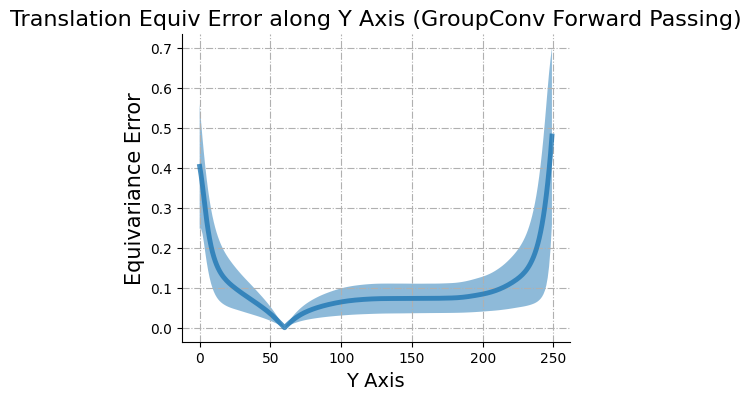

In [40]:
fig=plt.figure(figsize=(5, 4))
# remove boundary effects
# avg_equiv_error = avg_equiv_error[3:-3]
# std_equiv_error = std_equiv_error[3:-3]
plt.plot(avg_equiv_error,  linewidth = 3.5,  alpha=.8)
plt.fill_between(np.arange(len(avg_equiv_error)), (avg_equiv_error-std_equiv_error), (avg_equiv_error+std_equiv_error), alpha=.5)
plt.ylabel("Equivariance Error", size = 15)
plt.xlabel("Y Axis", size = 14)
plt.title("Translation Equiv Error along Y Axis (GroupConv Forward Passing)", size = 16)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(1)   
plt.grid(True, linestyle='-.')
# plt.show()
plt.savefig("translation_equiv_forward_passing.png", dpi = 200, bbox_inches = 'tight')